In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Check Data

In [ ]:
import torch
import matplotlib.pyplot as plt
from dataset import MNISTPatch

input image torch.Size([10, 16, 7, 7])


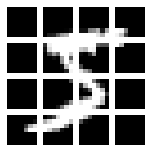

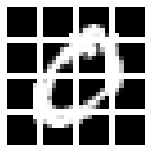

In [ ]:
dataset = MNISTPatch(n_device=16,root='./data', train=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)
x,y = next(iter(loader))
print('input image',x.shape)
for bdx in range(2):
    fig,axs = plt.subplots(4,4,figsize=(2,2), constrained_layout=True)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(x[bdx,i*4+j,:,:],cmap='gray')
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

input image torch.Size([10, 4, 14, 14])


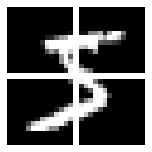

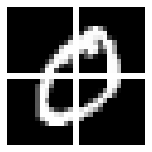

In [ ]:
dataset = MNISTPatch(n_device=4,root='./data', train=True)
loader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False)
x,y = next(iter(loader))
print('input image',x.shape)
for bdx in range(2):
    fig,axs = plt.subplots(2,2,figsize=(2,2), constrained_layout=True)
    for i in range(2):
        for j in range(2):
            axs[i,j].imshow(x[bdx,i*2+j,:,:],cmap='gray')
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

# Model and message passing

## Single Unit

In [ ]:
from model import DevicePerceptron, MessageConcat

In [ ]:
torch.randint(0, 5, (1,)).item()

4

In [ ]:
dmlp = DevicePerceptron(n_device=3,d_in=2,d_out=2)
ms = MessageConcat(max_num_elements=3)


print('weight',dmlp.state_dict()['weight'].shape)
print('bias',dmlp.state_dict()['bias'].shape)

weight torch.Size([3, 2, 2])
bias torch.Size([3, 2])


In [ ]:
# change weight and bias for sanity check
# check bias later
with torch.no_grad():
    for i in range(3):
        dmlp.weight[i,:,:] = torch.eye(2)*(i+1)
        dmlp.bias[i,:] = 0
print(dmlp.state_dict())

OrderedDict([('weight', tensor([[[1., 0.],
         [0., 1.]],

        [[2., 0.],
         [0., 2.]],

        [[3., 0.],
         [0., 3.]]])), ('bias', tensor([[0., 0.],
        [0., 0.],
        [0., 0.]]))])


In [ ]:
# One Sample
data = torch.Tensor([[1,1],[10,10],[100,100]]).unsqueeze(0)
print(data)

print('\n each server output')
data = dmlp(data)
print(data)

print('\n sending message')
edge_index = torch.tensor([[0, 0],
                           [1, 0],
                           [2, 0],
                           [1, 1],
                           [2, 2],
                           [1, 2]], dtype=torch.long).T

data = ms(data,edge_index)
for i in range(3):
    print(f'data at server {i}',data[:,i,:])

tensor([[[  1.,   1.],
         [ 10.,  10.],
         [100., 100.]]])

 each server output
tensor([[[  1.,   1.],
         [ 20.,  20.],
         [300., 300.]]], grad_fn=<ReluBackward0>)

 sending message
data at server 0 tensor([[  1.,   1.,  20.,  20., 300., 300.]], grad_fn=<SliceBackward0>)
data at server 1 tensor([[20., 20.,  0.,  0.,  0.,  0.]], grad_fn=<SliceBackward0>)
data at server 2 tensor([[300., 300.,  20.,  20.,   0.,   0.]], grad_fn=<SliceBackward0>)


In [ ]:
# Batch
bs = 2
data = torch.Tensor([[[1,1],[10,10],[100,100]],[[3,3],[30,30],[60,60]]])
print(data)

print('\n each server output')
data = dmlp(data).contiguous()
print(data)

print('\n sending message')
edge_index = torch.tensor([[0, 0],
                           [1, 0],
                           [2, 0],
                           [1, 1],
                           [2, 2],
                           [1, 2]], dtype=torch.long).T
edge_index_batch = []
for i in range(bs):
    edge_index_batch.append(edge_index.clone()+3*i)
edge_index = torch.cat(edge_index_batch,dim=1)
data = ms(data,edge_index)
for i in range(3):
    print(f'data at server {i}',data[:,i,:])

tensor([[[  1.,   1.],
         [ 10.,  10.],
         [100., 100.]],

        [[  3.,   3.],
         [ 30.,  30.],
         [ 60.,  60.]]])

 each server output
tensor([[[  1.,   1.],
         [ 20.,  20.],
         [300., 300.]],

        [[  3.,   3.],
         [ 60.,  60.],
         [180., 180.]]], grad_fn=<CloneBackward0>)

 sending message
data at server 0 tensor([[  1.,   1.,  20.,  20., 300., 300.],
        [  3.,   3.,  60.,  60., 180., 180.]], grad_fn=<SliceBackward0>)
data at server 1 tensor([[20., 20.,  0.,  0.,  0.,  0.],
        [60., 60.,  0.,  0.,  0.,  0.]], grad_fn=<SliceBackward0>)
data at server 2 tensor([[300., 300.,  20.,  20.,   0.,   0.],
        [180., 180.,  60.,  60.,   0.,   0.]], grad_fn=<SliceBackward0>)


## Full Model

In [ ]:
from model import MVFL

In [ ]:
model = MVFL(16,repeat=1)

In [ ]:
def get_batch_edge_index_MVFL(drop_mode, drop_rate, n_device, bs, return_device_valid=False):
    # TODO: find a better way to avoid using for loop
    # get edge_index for one sample
    edge_index = []
    n_receiver, n_sender = n_device, n_device

    if drop_mode == 'comm':
        device_valid = list(range(n_device))
        for i in range(n_sender):
            for j in range(n_receiver):
                # i - sender
                # j - receiver
                if i == j:
                    edge_index.append([j, i])
                else:
                    if torch.rand(1) > drop_rate:
                        edge_index.append([j, i])
    elif drop_mode == 'device':
        device_valid = []
        for i in range(n_sender):
            rand_check = torch.rand(1)
            if rand_check > drop_rate:
                device_valid.append(i)
            for j in range(n_receiver):
                # i - sender
                # j - receiver
                if i == j:
                    edge_index.append([j, i])
                else:
                    if rand_check > drop_rate:
                        edge_index.append([j, i])
    else:
        raise ValueError('drop_mode not recognized')
    edge_index = torch.Tensor(edge_index).T
    # repeat for  all samples in the batch
    edge_index_batch = []
    for i in range(bs):
        edge_index_batch.append(edge_index.clone() + n_device*i)
    edge_index = torch.cat(edge_index_batch, dim=1).long()
    if return_device_valid:
        return edge_index, device_valid
    else:
        return edge_index

In [ ]:
print(get_batch_edge_index(drop_mode='comm',drop_rate=1,n_device=16,bs=5).shape)
print(get_batch_edge_index(drop_mode='comm',drop_rate=0,n_device=16,bs=5).shape)

torch.Size([2, 80])
torch.Size([2, 1280])


In [ ]:
data = torch.randn(15,16,7,7)
edge_index = torch.tensor([[0, 0],
                           [1, 0],
                           [2, 0],
                           [1, 1],
                           [2, 2],
                           [1, 2]], dtype=torch.long).T
edge_index,device_valid = get_batch_edge_index(drop_mode='comm',drop_rate=0.5,n_device=16,bs=len(data),return_device_valid=True)
output = model(data,edge_index)
output = output[:,device_valid,:]
print('output',output.shape)
pred = output.argmax(dim=-1)
print('pred',pred.shape)


output torch.Size([15, 16, 10])
pred torch.Size([15, 16])


In [ ]:
data = torch.randn(15,16,7,7)
edge_index = torch.tensor([[0, 0],
                           [1, 0],
                           [2, 0],
                           [1, 1],
                           [2, 2],
                           [1, 2]], dtype=torch.long).T
edge_index,device_valid = get_batch_edge_index(drop_mode='device',drop_rate=0.5,n_device=16,bs=len(data),return_device_valid=True)
output = model(data,edge_index)
output = output[:,device_valid,:]
print('output',output.shape)
pred = output.argmax(dim=-1)
print('pred',pred.shape)

output torch.Size([15, 8, 10])
pred torch.Size([15, 8])


In [ ]:
def get_batch_edge_index_VFL(drop_mode, drop_rate, n_device, bs):
    # TODO: find a better way to avoid using for loop
    # get edge_index for one sample
    edge_index = []
    n_sender = n_device

    server_idx = torch.randint(0, n_device, (1,)).item()
    for i in range(n_sender):
        # i - sender
        # j - receiver
        if i == j:
            edge_index.append([server_idx, i])
        else:
            if torch.rand(1) > drop_rate:
                edge_index.append([server_idx, i])


    edge_index = torch.Tensor(edge_index).T
    # repeat for  all samples in the batch
    edge_index_batch = []
    for i in range(bs):
        edge_index_batch.append(edge_index.clone() + n_device*i)
    edge_index = torch.cat(edge_index_batch, dim=1).long()

    return edge_index


In [ ]:
print(get_batch_edge_index_VFL(drop_mode='comm',drop_rate=1,n_device=16,bs=5).shape)
print(get_batch_edge_index_VFL(drop_mode='comm',drop_rate=0,n_device=16,bs=5).shape)

torch.Size([2, 5])
torch.Size([2, 80])
